### Dataset

In [ ]:
# Montar Google Drive
from google.colab import drive
import shutil
import os

# Montar Google Drive
drive.mount('/content/drive')

# Ruta del archivo zip en tu Google Drive
# zip_path = '/content/drive/MyDrive/Fixcaps/Dataset/dataset_fix.zip'
zip_path = '/content/drive/MyDrive/ACSEI Grupo 2/Dataset/dataset_fix.zip'

# Copiar el archivo ZIP a la carpeta local de Colab para extracción rápida
local_zip_path = '/content/dataset_fix.zip'
shutil.copy(zip_path, local_zip_path)

# Ruta de destino en la carpeta local
local_extract_folder = '/content/dataset_fix/'

# Crear la carpeta si no existe
os.makedirs(local_extract_folder, exist_ok=True)

# Extraer el archivo ZIP localmente
shutil.unpack_archive(local_zip_path, local_extract_folder)

print(f'Archivos extraídos en: {local_extract_folder}')

Mounted at /content/drive
Archivos extraídos en: /content/dataset_fix/


In [ ]:
# Ruta del archivo zip del test set
zip_path = '/content/drive/MyDrive/ACSEI Grupo 2/Dataset/test_dir.zip'

# Copiar el archivo ZIP a la carpeta local de Colab para extracción rápida
local_zip_path = '/content/test_dir.zip'
shutil.copy(zip_path, local_zip_path)

# Ruta de destino en la carpeta local
local_extract_folder = '/content/test_dir/'

# Crear la carpeta si no existe
os.makedirs(local_extract_folder, exist_ok=True)

# Extraer el archivo ZIP localmente
shutil.unpack_archive(local_zip_path, local_extract_folder)

print(f'Archivos extraídos en: {local_extract_folder}')

Archivos extraídos en: /content/test_dir/


### Model

In [ ]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

loc_time = time.strftime("%H%M%S", time.localtime())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ratio = 8

class FixCapsNet(nn.Module):
    def __init__(self,conv_inputs,conv_outputs,
                 primary_units,primary_unit_size,
                 output_unit_size,num_classes=7,
                 init_weights=False,mode="DS"):
        super().__init__()

        self.Convolution = make_features(cfgs[mode],f_c=conv_inputs,out_c=conv_outputs)

        self.CBAM = Conv_CBAM(conv_outputs,conv_outputs)

        self.primary = Primary_Caps(in_channels=conv_outputs,#128
                                    caps_units=primary_units,#8
                                    )

        self.digits = Digits_Caps(in_units=primary_units,#8
                                   in_channels=primary_unit_size,#16*6*6=576
                                   num_units=num_classes,#classification_num
                                   unit_size=output_unit_size,#16
                                   )
        if init_weights:
            self._initialize_weights()

        # placeholder for the gradients and activations
        self.gradients = None
        self.activations = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.Convolution(x)
        x.requires_grad_(True)
        # We get the activations and gradients from the layer of interest (layer up4 in this case)
        h = x.register_hook(self.activations_hook)
        self.activations = x.clone().detach()

        x = self.CBAM(x)
        out = self.digits(self.primary(x))
        return out

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self):
        return self.activations

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    #margin_loss
    def loss(self, img_input, target, size_average=True):
        batch_size = img_input.size(0)
        # ||vc|| from the paper.
        v_mag = torch.sqrt(torch.sum(img_input**2, dim=2, keepdim=True))

        # Calculate left and right max() terms from equation 4 in the paper.
        zero = Variable(torch.zeros(1)).to(device)
        m_plus, m_minus = 0.9, 0.1
        max_l = torch.max(m_plus - v_mag, zero).view(batch_size, -1)**2
        max_r = torch.max(v_mag - m_minus, zero).view(batch_size, -1)**2
        # This is equation 4 from the paper.
        loss_lambda = 0.5
        T_c = target
        L_c = T_c * max_l + loss_lambda * (1.0 - T_c) * max_r
        L_c = torch.sum(L_c,1)

        if size_average:
            L_c = torch.mean(L_c)

        return L_c

class Primary_Caps(nn.Module):
    def __init__(self, in_channels, caps_units):
        super(Primary_Caps, self).__init__()

        self.in_channels = in_channels
        self.caps_units = caps_units

        def create_conv_unit(unit_idx):
            unit = ConvUnit(in_channels=in_channels)
            self.add_module("Caps_" + str(unit_idx), unit)
            return unit
        self.units = [create_conv_unit(i) for i in range(self.caps_units)]

    #no_routing
    def forward(self, x):
        # Get output for each unit.
        # Each will be (batch, channels, height, width).
        u = [self.units[i](x) for i in range(self.caps_units)]
        # Stack all unit outputs (batch, unit, channels, height, width).
        u = torch.stack(u, dim=1)
        # Flatten to (batch, unit, output).
        u = u.view(x.size(0), self.caps_units, -1)
        # Return squashed outputs.
        return squash(u)

class Digits_Caps(nn.Module):
    def __init__(self, in_units, in_channels, num_units, unit_size):
        super(Digits_Caps, self).__init__()

        self.in_units = in_units
        self.in_channels = in_channels
        self.num_units = num_units

        self.W = nn.Parameter(torch.randn(1, in_channels, self.num_units, unit_size, in_units))

    #routing
    def forward(self, x):
        batch_size = x.size(0)
        # (batch, in_units, features) -> (batch, features, in_units)
        x = x.transpose(1, 2)
        # (batch, features, in_units) -> (batch, features, num_units, in_units, 1)
        x = torch.stack([x] * self.num_units, dim=2).unsqueeze(4)
        # (batch, features, in_units, unit_size, num_units)
        W = torch.cat([self.W] * batch_size, dim=0)
        # Transform inputs by weight matrix.
        # (batch_size, features, num_units, unit_size, 1)
        u_hat = torch.matmul(W, x)
        # Initialize routing logits to zero.
        b_ij = Variable(torch.zeros(1, self.in_channels, self.num_units, 1)).to(device)

        num_iterations = 3
        for iteration in range(num_iterations):
            # Convert routing logits to softmax.
            # (batch, features, num_units, 1, 1)
            #c_ij = F.softmax(b_ij, dim=0)
            c_ij = b_ij.softmax(dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            # Apply routing (c_ij) to weighted inputs (u_hat).
            # (batch_size, 1, num_units, unit_size, 1)
            # s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            s_j = torch.sum(c_ij * u_hat, dim=1, keepdim=True)

            # (batch_size, 1, num_units, unit_size, 1)
            v_j = squash(s_j)#CapsuleLayer.squash

            # (batch_size, features, num_units, unit_size, 1)
            v_j1 = torch.cat([v_j] * self.in_channels, dim=1)

            # (1, features, num_units, 1)
            u_vj1 = torch.matmul(u_hat.transpose(3, 4), v_j1).squeeze(4).mean(dim=0, keepdim=True)

            # Update b_ij (routing)
            b_ij = b_ij + u_vj1

        return v_j.squeeze(1)

class ConvUnit(nn.Module):
    def __init__(self, in_channels):
        super(ConvUnit, self).__init__()
        Caps_out = in_channels // ratio
        self.Cpas = nn.Sequential(
                        nn.Conv2d(in_channels,Caps_out,9,stride=2,groups=Caps_out, bias=False),
                    )

    def forward(self, x):
        output = self.Cpas(x)
        return output

def squash(s):
    mag_sq = torch.sum(s**2, dim=2, keepdim=True)
    mag = torch.sqrt(mag_sq)
    s = (mag_sq / (1.0 + mag_sq)) * (s / mag)
    return s

class Conv_CBAM(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):
        super(Conv_CBAM, self).__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)#LayerNorm(c2, eps=1e-6, data_format="channels_first")#
        self.act = nn.Hardswish() if act else nn.Identity()
        self.ca = ChannelAttention(c2, reduction=1)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.act(self.bn(self.conv(x)))
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

def autopad(k, p=None):  # kernel, padding
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]
    return p

# SAM:This is different from the paper[S. Woo, et al. "CBAM: Convolutional Block Attention Module,"].
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7)
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size,padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# CAM
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        me_c = channels // reduction
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1   = nn.Conv2d(channels, me_c, 1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2   = nn.Conv2d(me_c, channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

def make_features(cfg: list,f_c,out_c=None,g=1,step=2):
    layers = []
    output = out_c
    f_channels = f_c
    for i in range(len(cfg)):
        if cfg[i] == 'N':
            g = 3

    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(2, 2)]
        elif v == "A":
            layers += [nn.AdaptiveMaxPool2d(20)]
        elif v == "F":
            layers += [nn.FractionalMaxPool2d(2, output_size=(20,20))]
        elif v == "B":
            f_channels = out_c
            layers += [nn.BatchNorm2d(f_channels,affine=True)]
            # layers += [LayerNorm(f_channels, eps=1e-6, data_format="channels_first")]
        elif v == "R":
            layers += [nn.ReLU(inplace=True)]
        elif v == "N":
            layers += [nn.Conv2d(f_channels,out_c,1,stride=step)]
        elif v == "C":
            layers += [nn.Conv2d(f_channels,f_channels,3,stride=step)]
        else:
            layers += [nn.Conv2d(f_channels, v, 18,stride=step,groups=g)]
            f_channels = v
    return nn.Sequential(*layers)

cfgs= {
    "DS": [3,'N','B','R','F'],# g = 3,  primary_unit_size = 16 * 6 * 6
    "DS2": ["C",3,'N','B','R','F'],# g = 3,  primary_unit_size = 16 * 6 * 6
    "256" : [256,'R','F'],# g = 1,  primary_unit_size = 32 * 6 * 6
    "128" : [128,'R','F'],# g = 1, primary_unit_size = 16 * 6 * 6
    "64"  : [64,'R','F'],# g = 1 , primary_unit_size = 8 * 6 * 6

}

### Utils

In [ ]:
!pip install thop

In [ ]:
import torch
import numpy as np
import seaborn as sns
import prettytable
import matplotlib.pyplot as plt
from thop.profile import profile
import time

class  ImageShow(object):
    def __init__(self,
                train_loss_list,train_acc_list,
                test_loss_list,test_acc_list,
                test_auc_list,
                val_loss_list,val_acc_list):
        self.trainll, self.trainacl = train_loss_list, train_acc_list
        self.testll, self.testacl = test_loss_list, test_acc_list
        self.testauc = test_auc_list
        self.valll, self.valacl = val_loss_list, val_acc_list

    def train(self,opt="Loss",write=True,custom_path=None,img_title=None,suf=None):
        if opt == 'Acc':
            img_portray(opt=opt,write=write,dates=self.trainacl,
                        #location='upper left',
                        label='Train_Acc',col='red',
                        img_title=img_title,suf=suf)
        elif opt == 'Loss':
            img_portray(opt=opt,write=write,dates=self.trainll,
                        #location='upper right',
                        linestyle="--",
                        label='Train_Loss',col='green',
                        img_title=img_title,suf=suf)
        if write:
            save_images(img_title=img_title,suf=suf,opt=opt)
        plt.show()

    def test(self,opt='Acc',write=True,custom_path=None,img_title=None,suf=None,**kwargs):
        if opt == 'Acc':
            img_portray(opt=opt,write=write,dates=self.testacl,
                        #location='upper left',
                        label='Test_Acc',col='red',
                        img_title=img_title,suf=suf)
        elif opt == 'Loss':
            img_portray(opt=opt,write=write,dates=self.testll,
                        #location='upper right',
                        linestyle="-.",
                        label='Test_Loss',col='green',
                        img_title=img_title,suf=suf)
        if write:
            save_images(split='test',img_title=img_title,suf=suf,opt=opt)
        plt.show()

    def val(self,opt='Acc',write=True,custom_path=None,img_title=None,suf=None):
        if opt == 'Acc':
            img_portray(opt=opt,write=write,dates=self.valacl,
                        linestyle="dotted",col='red',
                        label='Val_Acc',#location='upper left',
                        img_title=img_title,suf=suf)
        elif opt == 'Loss':
            img_portray(opt=opt,write=write,dates=self.valll,
                        linestyle="-.",col='green',
                        label='Val_Loss',#location='upper right',
                        img_title=img_title,suf=suf)
        if write:
            save_images(split='Val',img_title=img_title,suf=suf,opt=opt)
        plt.show()

    def conclusion(self,opt="test",img_title=None):
        if opt == "test" and len(self.testacl) != 0:
            print(f'\033[31m=================Conclusion====================\033[0m')
            best_idx = self.testacl.index(max(self.testacl))
            # val_idx = (best_idx+1)-1
            best_epoch = (best_idx+1)
            print(f"Dataset:[\033[1;31m{img_title}\033[0m]")
            print(f"Best_Epoch [\033[1;31m{best_epoch}\033[0m]")
            # print("[Train] loss {self.trainll[best_epoch-1]};")
            print(f"[Test] \033[31mACC:{round(float(self.testacl[best_idx]),2)}%\033[0m.")
            # Loss:{self.testll[best_idx]}, AUC:{round(float(self.testauc[best_idx]),2)}%
            # print(f"[Test]:\033[32mVal_ACC:{round(float(max(self.testauc)),2)}%\033[0m.")
        if opt == "val" and len(self.valacl) != 0:
            print(f'\033[31m=================Conclusion====================\033[0m')
            best_idx = self.valacl.index(max(self.valacl))
            best_epoch = (best_idx+1)
            print(f"Dataset:[\033[1;31m{img_title}\033[0m]")
            print(f"Best_Epoch [\033[1;31m{best_epoch}\033[0m]")
            print(f"[Val] \033[31mACC:{round(float(self.valacl[best_idx]),2)}%\033[0m.")

        if opt == "auc" and len(self.testauc) != 0:
            print(f'\033[31m=================Conclusion====================\033[0m')
            best_idx = self.testauc.index(max(self.testauc))
            val_idx = (best_idx+1)-1
            best_epoch = (best_idx+1)
            print(f"Dataset:[\033[1;31m{img_title}\033[0m]")
            print(f"Best_Epoch [\033[1;31m{best_epoch}\033[0m]\n[Train] loss:{self.trainll[best_epoch-1]};")
            print(f"[Test] Loss:{self.testll[best_idx]}, \033[32mACC:{round(float(self.testacl[best_idx]),2)}%\033[0m.")
            print(f"[Test]:\033[32m AUC:{round(float(self.testauc[best_idx]),2)}%\033[0m.")

def img_portray(opt='Acc',write=True,
                split=None,custom_path='./tmp',
                dates=None,linestyle="dotted",
                label=None,col=None,location='best',
                img_title=None,suf=None):
    plt.style.use("seaborn")
    plt.title(img_title)
    plt.xlabel("Epochs")
    if opt == 'Acc' and dates != None:
        epoch_nums = np.arange(len(dates))
        y = dates
        img_max = np.argmax(y)
        show_max = round(float(y[img_max]),2)
        plt.plot(img_max,show_max ,'8')
        plt.annotate(show_max,xy=(img_max,show_max),xytext=(img_max,show_max))
        plt.plot(epoch_nums, y, linestyle=linestyle,c=col,label=label)
        plt.ylabel("Accuracy")
        plt.legend(loc=location)
    elif opt == 'Loss' and dates != None:
        epoch_nums= np.arange(len(dates))
        y = torch.tensor(dates,device='cpu')
        img_min = np.argmin(y)
        show_min = round(float(y[img_min]),6)

        plt.annotate(show_min,xy=(img_min,show_min),xytext=(img_min,show_min))
        plt.plot(img_min,show_min,'8')
        plt.plot(epoch_nums, y,linestyle=linestyle,c=col,label=label)
        plt.ylabel("Loss")
        plt.legend(loc=location)
    else:
        print("Please input the right decision.")

def save_images(split='train',custom_path='./tmp',img_title=None,suf=None,opt=None):
    if split == 'train':
        plt.savefig(f'{custom_path}/{img_title}/{suf}/{split}_{opt}.png',dpi=300)
    else:
        plt.savefig(f'{custom_path}/{img_title}/{suf}/{split}_{opt}.png',dpi=300)

def draw_size_acc(data_dict,custom_path='./tmp',img_title=None,suf=None,opt=None):
    sx=[]
    sy=[]

    for i in range(len(data_dict)):
        x=sorted(data_dict.items(), key=lambda x: x[0])[i][0]
        y=sorted(data_dict.items(), key=lambda x: x[0])[i][1]
        sx.append(x)
        sy.append(y)

    plt.style.use("seaborn")
    plt.plot(sx, sy,label="Test_Data")
    plt.ylabel("Accuracy")
    plt.xlabel("Image_Size")
    plt.legend(loc="best")

    plt.savefig(f'{custom_path}/{img_title}/{suf}/Size_Accuracy.png',dpi=300)

def confusion_matrix(evl_result,n_cla,cla_dict,data,img_title=None,suf=None):
    plt.figure(figsize=(12,9))
    sb = range(n_cla)
    sns.heatmap(evl_result,annot=True,cmap="Blues",cbar=True,fmt="g", annot_kws={"size": 20})
    plt.yticks([index + 0.5 for index in sb],cla_dict.values(),fontsize=16)
    plt.xticks([index + 0.5 for index in sb],cla_dict.values(),fontsize=16)

    plt.title("Confusion Matrix",fontsize=24)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=16)

    # vname = lambda v,nms: [ vn for vn in nms if id(v)==id(nms[vn])][0]
    # kn = vname(evl_result,locals())
    if evl_result.sum().item() == len(data):
        kn = 'test'
    else:
        kn = 'val'

    plt.savefig(f"./tmp/{img_title}/{suf}/Confusion_Matrix_{kn}.png",dpi=300)

def metrics_scores(evl_result,n_classes,cla_dict):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Type','Precision', 'Recall', 'F1','Accuracy']
    accuracy = float(torch.sum(evl_result.diagonal())/torch.sum(evl_result))
    for i in range(n_classes):
        pre = float(evl_result[i][i] / torch.sum(evl_result,0)[i])
        recall = float(evl_result[i][i] / torch.sum(evl_result,1)[i])
        F1 = pre * recall * 2 / (pre + recall + 1e-8)
        result_table.add_row([cla_dict[i], round(pre, 4), round(recall, 3), round(F1, 3)," "])

    result_table.add_row(["Total:", " ", " ", " ",round(accuracy,4)])
    print(result_table)

def one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

def pff(m_name,model,inputes):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Model','Params(M)', 'FLOPs(G)', 'FPS']

    total_ops, total_params = profile(model, (inputes,), verbose=False)
    Params = total_params / (1000 ** 2)
    ops = total_ops / (1000 ** 3)

    model.eval()
    with torch.no_grad():
        torch.cuda.synchronize()
        start = time.time()
        output= model(inputes)
        torch.cuda.synchronize()
        end = time.time()
        single_fps = 1/(end-start)

    result_table.add_row([m_name, round(Params, 2), round(ops, 2), round(single_fps, 2)])
    print(result_table)

###
def create_initial_checkpoint(model, optimizer, scheduler, epoch, best_train, metrics):
    return {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_train': best_train,
        'metrics': metrics
    }

def save_checkpoint(checkpoint, filename):
    torch.save(checkpoint, filename)

def load_checkpoint(filename, model, optimizer, scheduler):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch'], checkpoint['best_train'], checkpoint['metrics']

### FixCaps

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import torch
import sys, os
import json
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

# from utils import ImageShow,draw_size_acc,one_hot
# from utils import confusion_matrix,metrics_scores,pff

# from model import FixCapsNet

In [ ]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}

#defined
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [ ]:
def get_data(trans_test='312'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((302,302)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    data_root = os.path.abspath(os.path.join(os.getcwd(),".."))  # get data root path
    # image_path = os.path.join(data_root, "datasets","HAM10000")#
    # assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    # Configurar rutas de datos
    train_path = "/content/dataset_fix/train525s8"
    val_path = "/content/dataset_fix/val525s8"
    test_path = "/content/test_dir/test_dir"

    # Cargar conjuntos de datos
    train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform['train'])
    val_dataset = datasets.ImageFolder(root=val_path, transform=data_transform['val'])
    test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform['test'])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)

    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)

    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [ ]:
BatchSize = 168
V_size = 40
T_size = 32
train_doc = "train525e384"
val_doc = "val525png384"
test_doc = "test525png384"

nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6])
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 2 dataloader workers every process.
Using 7 classes.
using 48322 images for training, 5970 images for validation, 828 images for testing.


In [ ]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 141, 141]         124,544
              ReLU-2        [-1, 128, 141, 141]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [ ]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(18, 18), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [ ]:
dsize = (1, 3, 299, 299)
input_data = torch.randn(dsize).to(device)
pff(m_name="FixCaps"+'-'+mode,model=network,inputes=input_data)

+-------------+-----------+----------+------+
|    Model    | Params(M) | FLOPs(G) | FPS  |
+-------------+-----------+----------+------+
| FixCaps-128 |    0.26   |   2.48   | 42.3 |
+-------------+-----------+----------+------+


In [ ]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        output = network(data)
        loss = network.loss(output, target, size_average=True)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)

        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size

        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 80:
            torch.save(network.state_dict(), iter_path)

    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}/train_evl_result.pth')

    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))
    #---------------------------------------------------------------------------------------------------------
    metrics = {
        'train_loss': train_loss_list,
        'train_acc': train_acc_list,
        'val_loss': val_loss_list,
        'val_acc': val_acc_list,
        'test_loss': test_loss_list,
        'test_acc': test_acc_list
    }
    checkpoint = create_initial_checkpoint(network, optimizer, scheduler, epoch, best_train, metrics)
    checkpoint_path = f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/HAM10000/0923_060705/checkpoint_epoch_{epoch}.pth'
    save_checkpoint(checkpoint, checkpoint_path)

In [ ]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)

    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num

    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])
            target_one_hot = one_hot(target, length=n_classes)
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]

            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size

            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result)
        test_acc = 100. * float(torch.div(diag_sum,all_sum))
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
                torch.save(test_evl_result, f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")


In [ ]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")
if os.path.exists(f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}'):
    print (f'Store: "/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}"')
else:
    os.makedirs(f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}', exist_ok=True)
iter_path = f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}/train_{img_title}_{suf}.pth'
save_PATH = f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}/best_{img_title}_{suf}.pth'
last_path = f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/{img_title}/{suf}/last_{img_title}_{suf}.pth'
print(save_PATH)

suf:1015_052639
/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/HAM10000/1015_052639/best_HAM10000_1015_052639.pth


In [ ]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate,
#                         steps_per_epoch=len(train_loader),
#                         epochs=num_epochs)

In [ ]:
num_epochs = 120

In [ ]:
#---------------------------------------------------------------------------------------------------------------------
# Crear el checkpoint inicial
last_epoch = 120  # O el número de la última época que recuerdes
best_model_path = '/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/HAM10000/1013_174523/best_HAM10000_0923_060705.pth'

if os.path.exists(best_model_path):
    print("Loading the best model...")
    network.load_state_dict(torch.load(best_model_path))

    metrics = {
        'train_loss': train_loss_list,
        'train_acc': train_acc_list,
        'test_loss': test_loss_list,
        'test_acc': test_acc_list,
        'val_loss': val_loss_list,
        'val_acc': val_acc_list
    }

    initial_checkpoint = create_initial_checkpoint(network, optimizer, scheduler, last_epoch, best_train, metrics)

    checkpoint_path = f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/HAM10000/0923_060705/checkpoint_epoch_{last_epoch}.pth'
    save_checkpoint(initial_checkpoint, checkpoint_path)
    print(f"Created initial checkpoint at epoch {last_epoch}")
else:
    print("Best model file not found. Please check the file path.")


Loading the best model...
Created initial checkpoint at epoch 120


<ipython-input-23-1d9e094b5447>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(best_model_path))


In [ ]:
#------------------------------------------------------------------------------------------------------------------------------
# Modificar el bucle principal de entrenamiento
num_epochs = 120  # O el número total de épocas que desees entrenar
start_epoch = last_epoch + 1
latest_checkpoint_path = f'/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/HAM10000/0923_060705/checkpoint_epoch_{last_epoch}.pth'

if os.path.exists(latest_checkpoint_path):
    print("Loading latest checkpoint...")
    start_epoch, best_train, metrics = load_checkpoint(latest_checkpoint_path, network, optimizer, scheduler)
    train_loss_list = metrics['train_loss']
    train_acc_list = metrics['train_acc']
    val_loss_list = metrics['val_loss']
    val_acc_list = metrics['val_acc']
    test_loss_list = metrics['test_loss']
    test_acc_list = metrics['test_acc']
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("No checkpoint found. Please ensure you've created the initial checkpoint.")

Loading latest checkpoint...
Resuming training from epoch 120


<ipython-input-6-90a68663b697>:228: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [ ]:
for epoch in range(start_epoch, num_epochs + 1): #4h 26m 46s
    train(epoch)
    test('val')

print('Finished Training')

[Train Epoch:[120]HAM10000 ==> Training] ...


  0%|          | 0/288 [00:00<?, ?it/s]

[144/288] Loss0.22681,ACC:0.66720
Train Epoch:[120] Loss:0.23310,Acc:0.66696,Best_train:0.66696
HAM10000 ==> val ...


  0%|          | 0/150 [00:00<?, ?it/s]

val_Acc:80.134%
Best_val:[80.134%]
Finished Training


In [ ]:
show.conclusion(opt='val',img_title=img_title)

### Testing

In [ ]:
from torch.autograd import Variable
import random

def test_single_image(network, data_loader, device):
    network.eval()

    dataset = data_loader.dataset
    random_index = random.randint(0, len(dataset) - 1)
    data, target = dataset[random_index]

    # Asegurarse de que solo estamos usando una imagen
    data = data.unsqueeze(0)  # Añadir dimensión de batch

    # Mover los datos al dispositivo correcto
    data = data.to(device)
    data.requires_grad = True

    output = network(data)

    print(f"Shape of the output: {output.shape}")
    # print(f"Output: {output}")

    return output, target, data.cpu()

<ipython-input-81-0be1a2665bd8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load('/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/HAM

Shape of the output: torch.Size([1, 7, 16, 1])
PREDICTED CLASS:  Queratosis benigna
TRUE CLASS:  Queratosis benigna
torch.Size([299, 299, 3])


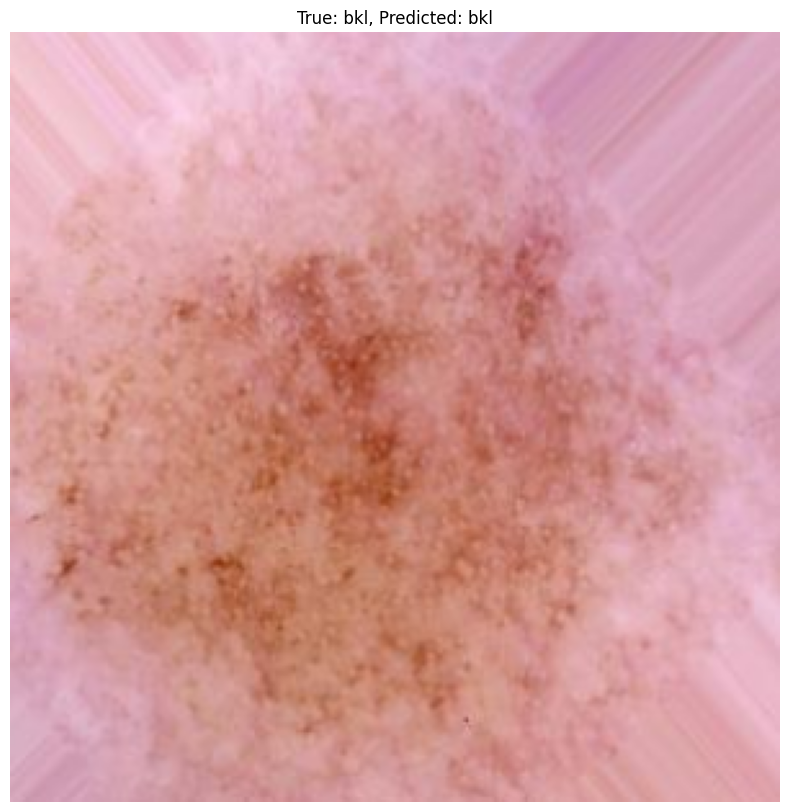

In [ ]:
class_names = {0: "akiec", 1: "bcc", 2: "bkl", 3: "df", 4: "mel", 5: "nv", 6: "vasc"}
lesion_names = {0: "Queratosis actínica", 1: "Carcinoma basocelular", 2: "Queratosis benigna", 3: "Dermatofibroma", 4: "Melanoma", 5: "Nevus melanocítico", 6: "Lesión vascular"}

# network.load_state_dict(torch.load(save_PATH))
network.load_state_dict(torch.load('/content/drive/MyDrive/ACSEI Grupo 2/main_fixcaps_29/HAM10000/1013_174523/best_HAM10000_0923_060705.pth'))
network = network.to(device)
output, target, img_tensor = test_single_image(network, val_loader, device) #si
magnitudes = torch.sqrt(torch.sum(output**2, dim=2)).squeeze()
predicted_class = torch.argmax(magnitudes).item()
print('PREDICTED CLASS: ', lesion_names[predicted_class])
print('TRUE CLASS: ', lesion_names[target])


# Mostrar la imagen
plt.figure(figsize=(10, 10))
img = img_tensor.squeeze(0).permute(1, 2, 0)
img = img * 0.5 + 0.5
print(img.size())

# Asegurar que los valores están en el rango [0, 1]
img = torch.clamp(img, 0, 1)
plt.imshow(img.detach().numpy())
plt.title(f"True: {class_names[target]}, Predicted: {class_names[predicted_class]}")
plt.axis('off')
plt.show()


### GradCAM

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

def gradcam(network, data_loader, device):
    network.eval()

    class_names = {0: "akiec", 1: "bcc", 2: "bkl", 3: "df", 4: "mel", 5: "nv", 6: "vasc"}
    dataset = data_loader.dataset
    random_index = random.randint(0, len(dataset) - 1)
    data, target = dataset[random_index]

    #Plotear la imagen original
    img = data.clone().squeeze(0).permute(1, 2, 0)
    img = img * 0.5 + 0.5
    img = torch.clamp(img, 0, 1)

    # Asegurarse de que solo estamos usando una imagen
    data = data.unsqueeze(0)  # Añadir dimensión de batch

    # Mover los datos al dispositivo correcto
    data = data.to(device)
    data.requires_grad = True

    # Obtain model predictions
    output = network(data) #torch.Size([1, 7, 16, 1])

    magnitudes = torch.sqrt(torch.sum(output**2, dim=2)).squeeze()
    predicted_class = torch.argmax(magnitudes).item()

    # Get the gradient of the output with respect to the parameters of the model
    output[:, predicted_class, 0, :].backward()

    # Pull the gradients out of the model
    gradients = network.get_activations_gradient()

    # Get the activations of the last convolutional layer
    activations = network.get_activations()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # weight the channels by corresponding gradients
    for i in range(128):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze().cpu()

    # relu on top of the heatmap
    heatmap = np.maximum(heatmap.numpy(), 0)

    # normalize the heatmap
    heatmap /= np.max(heatmap)

    # Convertir img a un array numpy de uint8
    img_np = (img.numpy() * 255).astype(np.uint8)

    # Redimensionar el heatmap al tamaño de la imagen original
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))

    # Normalizar el heatmap para que esté en el rango [0, 255]
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Aplicar colormap al heatmap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superponer el heatmap en la imagen original
    img_overlayed = cv2.addWeighted(cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR), 0.55, heatmap_colored, 0.45, 0)

    # Mostrar la imagen original, el heatmap y el heatmap superpuesto
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_np)
    axes[0].axis('off')
    axes[0].set_title('Original image')

    axes[1].imshow(heatmap_resized, cmap='jet', interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Heatmap')

    axes[2].imshow(cv2.cvtColor(img_overlayed, cv2.COLOR_BGR2RGB))
    axes[2].axis('off')
    axes[2].set_title('Superimposed Heatmap')

    plt.show()

    print(f"True: {class_names[target]}, Predicted: {class_names[predicted_class]}")

    # return output, target, data.cpu()

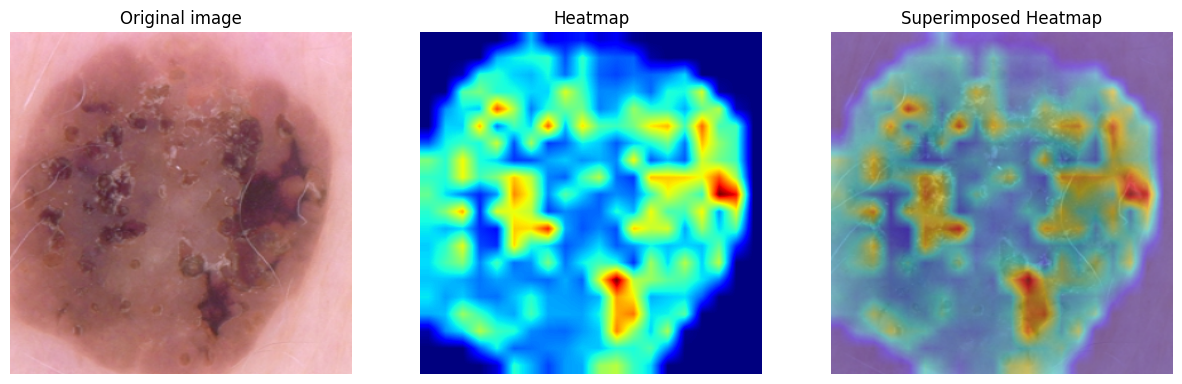

True: bkl, Predicted: bkl


In [ ]:
gradcam(network, train_loader, device)

In [ ]:
# for k in range(22,33):
#     T_size = k
#     print(f"T_size:{k}")
#     for i in range(300,325):
#         get_data(i)
#         print(f"size:{i}")
#         for j in range(5):
#             test()
#             if dict_imgSize.get(i) is None or dict_imgSize[i] < test_acc:
#                 dict_imgSize[i] = test_acc

#                 if dict_batch.get(k) is None or dict_batch[k] < test_acc:
#                     dict_batch[k] = test_acc

#             elif dict_batch.get(k) is None or dict_batch[k] < test_acc:
#                     dict_batch[k] = test_acc



In [ ]:
show.conclusion(img_title=img_title)
print(sorted(dict_imgSize.items(), key=lambda x: x[1] ,reverse=True)[0:9])
print(sorted(dict_batch.items(), key=lambda x: x[1], reverse=True)[0:9])

In [ ]:
draw_size_acc(dict_imgSize,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
metrics_scores(test_evl_result,n_classes,cla_dict)

In [ ]:
# #save
s0 = np.array(train_acc_list)
np.save(f'/content/drive/MyDrive/Fixcaps/main_fixcaps_29/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'/content/drive/MyDrive/Fixcaps/main_fixcaps_29/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'/content/drive/MyDrive/Fixcaps/main_fixcaps_29/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'/content/drive/MyDrive/Fixcaps/main_fixcaps_29/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)
s4 = np.array(dict_batch)
np.save(f'/content/drive/MyDrive/Fixcaps/main_fixcaps_29/{img_title}/{suf}/{img_title}_dict_batch_{suf}.npy', s2)

In [ ]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

In [ ]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
confusion_matrix(val_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
network.load_state_dict(torch.load(save_PATH))
dict_test = {}
dict_size = {}
test_doc = "test525png384"#"test525png"#
for k in range(23,24):
    T_size = k
    for i in range(301,321):
        get_data(i)
        print(f"size:{i}")
        for j in range(9):
            test()
            if dict_size.get(i) is None or dict_size[i] < test_acc:
                dict_size[i] = test_acc

                if dict_test.get(k) is None or dict_test[k] < test_acc:
                    dict_test[k] = test_acc

            elif dict_test.get(k) is None or dict_test[k] < test_acc:
                    dict_test[k] = test_acc

In [ ]:
show.conclusion(img_title=img_title)
print(sorted(dict_test.items(), key=lambda x: x[1], reverse=True)[0:9])
print(sorted(dict_size.items(), key=lambda x: x[1], reverse=True)[0:9])

In [ ]:
draw_size_acc(dict_size,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
metrics_scores(test_evl_result,n_classes,cla_dict)

In [ ]:
# network.load_state_dict(torch.load(save_PATH))
# dict_test = {}
# dict_size = {}
# test_doc = "test525png384"#"test525png"#
# for k in range(22,33):
#     T_size = k
#     for i in range(300,308):
#         get_data(i)
#         print(f"size:{i}")
#         for j in range(7):
#             test()
#             if dict_size.get(i) is None or dict_size[i] < test_acc:
#                 dict_size[i] = test_acc

#                 if dict_test.get(k) is None or dict_test[k] < test_acc:
#                     dict_test[k] = test_acc

#             elif dict_test.get(k) is None or dict_test[k] < test_acc:
#                     dict_test[k] = test_acc

In [ ]:
# show.conclusion(img_title=img_title)
# print(sorted(dict_test.items(), key=lambda x: x[1], reverse=True)[0:9])
# print(sorted(dict_size.items(), key=lambda x: x[1], reverse=True)[0:9])

In [ ]:
save_PATH = '' # path del modelo

# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
network.load_state_dict(torch.load(save_PATH))

data =